### 千葉県船橋市の物件をスクレイピング

In [ ]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib.parse
import time
import numpy as np
import pandas as pd
import logging
import sqlite3
from datetime import datetime

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='scraping.log'
)

# ヘッダー設定
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# SUUMOを船橋市のワンルームに絞る
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&pc=30&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sc=12204&ta=12&cb=0.0&ct=9999999&md=01&et=9999999&mb=0&mt=9999999&cn=9999999&fw2='

def get_total_pages(soup):
    """
    検索結果の総ページ数を取得する関数
    
    Args:
        soup (BeautifulSoup): BeautifulSoupオブジェクト
    
    Returns:
        int: 総ページ数。取得できない場合は1を返す
    """
    try:
        pagination = soup.find(class_='pagination pagination_set-nav')
        if pagination:
            pages = pagination.find_all('a')
            if pages:
                # ページネーションの最後から2番目の要素が最終ページ
                # （最後の要素は「次へ」ボタン）
                return int(pages[-2].text)
        return 1
    except Exception as e:
        logging.error(f"総ページ数の取得に失敗: {e}")
        return 1

class RateLimiter:
    def __init__(self, requests_per_second=1):
        self.requests_per_second = requests_per_second
        self.last_request_time = 0

    def wait(self):
        current_time = time.time()
        elapsed_time = current_time - self.last_request_time
        if elapsed_time < (1 / self.requests_per_second):
            time.sleep((1 / self.requests_per_second) - elapsed_time)
        self.last_request_time = time.time()

# カウンター用クラス
class ScrapingCounter:
    def __init__(self):
        self.total_properties = 0
        self.total_buildings = 0
        self.properties_per_page = []
    
    def add_page_stats(self, buildings, properties):
        self.total_buildings += buildings
        self.total_properties += properties
        self.properties_per_page.append(properties)
    
    def get_stats(self):
        return {
            'total_properties': self.total_properties,
            'total_buildings': self.total_buildings,
            'avg_properties_per_page': np.mean(self.properties_per_page) if self.properties_per_page else 0
        }

# データベース初期化関数
def init_database():
    conn = sqlite3.connect('suumo_properties.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        category TEXT,
        building_name TEXT,
        address TEXT,
        nearest_station1 TEXT,
        nearest_station2 TEXT,
        nearest_station3 TEXT,
        building_age TEXT,
        total_floors TEXT,
        room_floor TEXT,
        rent TEXT,
        management_fee TEXT,
        deposit TEXT,
        gratuity TEXT,
        layout TEXT,
        area TEXT,
        url TEXT,
        page_number INTEGER
    )
    ''')
    
    conn.commit()
    return conn, cursor

def insert_to_database(conn, cursor, data_samples, current_page, rate_limiter, counter):
    scrape_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    insert_query = '''
    INSERT INTO properties (
        scrape_date, category, building_name, address, 
        nearest_station1, nearest_station2, nearest_station3, building_age, 
        total_floors, room_floor, rent, management_fee, 
        deposit, gratuity, layout, area, url, page_number
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    '''
    
    insert_data = []
    for sample in data_samples:
        insert_data.append((
            scrape_date, 
            sample[0], sample[1], sample[2], 
            sample[3], sample[4], sample[5], sample[6], 
            sample[7], sample[8], sample[9], sample[10], 
            sample[11], sample[12], sample[13], sample[14],
            sample[15], current_page
        ))
        
        rate_limiter.wait()
        print("---物件情報---")
        print(f"データ件数：{counter.total_properties + 1}")  # カウンターに1を加算する前の値を表示
        print(f"カテゴリ: {sample[0]}")
        print(f"建物名: {sample[1]}")
        print(f"住所: {sample[2]}")
        print(f"最寄り駅1: {sample[3]}")
        print(f"最寄り駅2: {sample[4]}")
        print(f"最寄り駅3: {sample[5]}")
        print(f"築年数: {sample[6]}")
        print(f"総階数: {sample[7]}")
        print(f"部屋階: {sample[8]}")
        print(f"家賃: {sample[9]}")
        print(f"管理費: {sample[10]}")
        print(f"敷金: {sample[11]}")
        print(f"礼金: {sample[12]}")
        print(f"間取り: {sample[13]}")
        print(f"面積: {sample[14]}")
        print(f"URL: {sample[15]}")
        print("---------------\n")
        counter.total_properties += 1  # 物件数をカウントアップ
    
    cursor.executemany(insert_query, insert_data)
    conn.commit()

@retry(tries=3, delay=10, backoff=2)
def load_page(url, rate_limiter):
    try:
        rate_limiter.wait()
        html = requests.get(url, headers=headers, timeout=10)
        html.raise_for_status()
        soup = BeautifulSoup(html.content, 'html.parser')
        return soup
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise
        
def export_to_csv(conn):# データベースからCSVファイルに出力いらない
    df = pd.read_sql_query("SELECT * FROM properties", conn)
    
    filename = f'suumo_properties_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\nCSVファイル {filename} に出力しました。")
    
    print("\n--- データ概要 ---")
    print(f"総物件数: {len(df)}")
    
    try:
        df['rent_numeric'] = df['rent'].str.replace('万円', '').astype(float)
        print(f"平均家賃: {df['rent_numeric'].mean():.2f}万円")
    except:
        print("家賃の平均計算に失敗しました。")
    
    print(f"物件カテゴリ内訳:\n{df['category'].value_counts()}")

def main():
    rate_limiter = RateLimiter(requests_per_second=1)
    counter = ScrapingCounter()
    
    conn, cursor = init_database()
    data_samples = []

    first_page_soup = load_page(url, rate_limiter)
    max_page = get_total_pages(first_page_soup)
    
    start = time.time()
    times = []

    try:
        for page in range(1, max_page+1):
            before = time.time()
            page_properties = 0  # このページの物件数
            
            page_url = f"{url}&page={page}" if page > 1 else url
            
            soup = load_page(page_url, rate_limiter)
            
            mother = soup.find_all(class_='cassetteitem')
            buildings_count = len(mother)  # この階の建物数
            
            for child in mother:
                data_home = []
                
                try:
                    data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_content-title').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_detail-col1').text)
                except:
                    data_home.append('不明')
                
                try:
                    children = child.find(class_='cassetteitem_detail-col2')
                    stations = children.find_all(class_='cassetteitem_detail-text')
                    for id, grandchild in enumerate(stations[:3]):
                        data_home.append(grandchild.text)
                    while len(data_home) < 6:
                        data_home.append('不明')
                except:
                    data_home.extend(['不明', '不明', '不明'])
                
                try:
                    children = child.find(class_='cassetteitem_detail-col3')
                    building_info = children.find_all('div')
                    data_home.extend([building_info[0].text, building_info[1].text])
                except:
                    data_home.extend(['不明', '不明'])

                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    
                    room_tds = room.find_all('td')
                    for id_, grandchild in enumerate(room_tds):
                        try:
                            if id_ == 2:
                                data_room.append(grandchild.text.strip())
                            
                            elif id_ == 3:
                                rent = grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text
                                management_fee = grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text
                                data_room.append(rent)
                                data_room.append(management_fee)
                            
                            elif id_ == 4:
                                deposit = grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text
                                gratuity = grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text
                                data_room.append(deposit)
                                data_room.append(gratuity)
                            
                            elif id_ == 5:
                                layout = grandchild.find(class_='cassetteitem_madori').text
                                area = grandchild.find(class_='cassetteitem_menseki').text
                                data_room.append(layout)
                                data_room.append(area)
                            
                            elif id_ == 8:
                                get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                                abs_url = urllib.parse.urljoin(url, get_url)
                                data_room.append(abs_url)
                        
                        except Exception as e:
                            data_room.append('不明')
                    
                    data_sample = data_home + data_room
                    data_samples.append(data_sample)
                    page_properties += 1
            
            # ページの統計を追加
            counter.add_page_stats(buildings_count, page_properties)
            
            insert_to_database(conn, cursor, data_samples, page, rate_limiter, counter)
            data_samples = []
            
            after = time.time()
            running_time = after - before
            times.append(running_time)
            
            stats = counter.get_stats()
            print(f'\n{page}ページ目の統計:')
            print(f'このページの建物数: {buildings_count}')
            print(f'このページの物件数: {page_properties}')
            print(f'累計建物数: {stats["total_buildings"]}')
            print(f'累計物件数: {stats["total_properties"]}')
            print(f'ページあたり平均物件数: {stats["avg_properties_per_page"]:.1f}')
            print(f'処理時間: {running_time:.1f}秒')
            
            complete_ratio = round(page/max_page*100, 3)
            print(f'完了：{complete_ratio}%')
            
            running_mean = np.mean(times)
            running_required_time = running_mean * (max_page - page)
            hour = int(running_required_time/3600)
            minute = int((running_required_time%3600)/60)
            second = int(running_required_time%60)
            print(f'残り時間：{hour}時間{minute}分{second}秒\n')

            logging.info(f'ページ {page} スクレイピング完了 (建物数: {buildings_count}, 物件数: {page_properties})')

    except Exception as e:
        logging.error(f"スクレイピング中にエラー発生: {e}")
        print(f"エラー: {e}")
    
    finish = time.time()
    running_all = finish - start
    
    # 最終統計
    final_stats = counter.get_stats()
    print('\n=== 最終統計 ===')
    print(f'総建物数: {final_stats["total_buildings"]}')
    print(f'総物件数: {final_stats["total_properties"]}')
    print(f'ページあたり平均物件数: {final_stats["avg_properties_per_page"]:.1f}')
    print(f'総経過時間: {running_all:.1f}秒')

    export_to_csv(conn)
    conn.close()
    logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

---物件情報---
データ件数：167
カテゴリ: 賃貸アパート
建物名: アロー坪井 33番館
住所: 千葉県船橋市坪井東１
最寄り駅1: 東葉高速鉄道/船橋日大前駅 歩3分
最寄り駅2: 新京成線/北習志野駅 歩25分
最寄り駅3: 東葉高速鉄道/八千代緑が丘駅 歩22分
築年数: 築3年
総階数: 3階建
部屋階: 2階
家賃: 7.5万円
管理費: 3000円
敷金: 11.25万円
礼金: 7.5万円
間取り: ワンルーム
面積: 25.12m2
URL: https://suumo.jp/chintai/jnc_000095757063/?bc=100417559589
---------------

---物件情報---
データ件数：168
カテゴリ: 賃貸マンション
建物名: ベルクレール拾伍番館
住所: 千葉県船橋市本町２
最寄り駅1: ＪＲ総武線/船橋駅 歩7分
最寄り駅2: 京成本線/京成船橋駅 歩6分
最寄り駅3: ＪＲ京葉線/南船橋駅 歩29分
築年数: 築24年
総階数: 8階建
部屋階: 3階
家賃: 5.5万円
管理費: 5000円
敷金: -
礼金: -
間取り: ワンルーム
面積: 19.42m2
URL: https://suumo.jp/chintai/jnc_000094562155/?bc=100408663524
---------------

---物件情報---
データ件数：169
カテゴリ: 賃貸マンション
建物名: ベルクレール拾伍番館
住所: 千葉県船橋市本町２
最寄り駅1: ＪＲ総武線/船橋駅 歩7分
最寄り駅2: 京成本線/京成船橋駅 歩6分
最寄り駅3: ＪＲ京葉線/南船橋駅 歩29分
築年数: 築24年
総階数: 8階建
部屋階: 4階
家賃: 5.6万円
管理費: 5000円
敷金: -
礼金: -
間取り: ワンルーム
面積: 19.88m2
URL: https://suumo.jp/chintai/jnc_000094398874/?bc=100406883818
---------------

---物件情報---
データ件数：170
カテゴリ: 賃貸マンション
建物名: ベルクレール拾伍番館
住所: 千葉県船橋市本町２
最寄り駅1: ＪＲ総武線/船橋駅 歩7分
最寄り駅2: 京成本線

### 千葉県船橋市の物件の面積と家賃の関係を散布図で表す

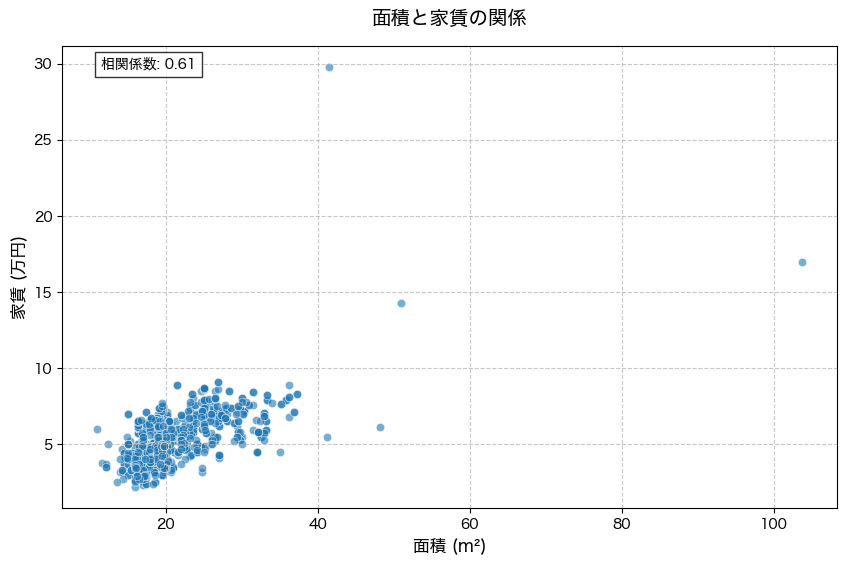


基本統計量:
          家賃 (万円)     面積 (m²)
count  927.000000  927.000000
mean     5.579752   21.520086
std      1.751380    5.741339
min      2.200000   11.020000
25%      4.400000   17.965000
50%      5.500000   19.820000
75%      6.700000   25.010000
max     29.800000  103.680000


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import logging

# ロギング設定
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='property_analysis.log'
)

def connect_to_db():
    """データベースに接続する関数"""
    try:
        conn = sqlite3.connect('suumo_properties.db')
        return conn
    except Exception as e:
        logging.error(f"データベース接続エラー: {e}")
        raise

def clean_numeric_data(value):
    """数値データをクリーニングする関数"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        # 家賃データのクリーニング（例：'5.2万円' → 5.2）
        if '万円' in value:
            return float(value.replace('万円', ''))
        # 面積データのクリーニング（例：'45m2' → 45.0）
        if 'm2' in value:
            return float(value.replace('m2', ''))
    return value

def create_rent_area_scatter():
    """家賃と面積の散布図を作成する関数"""
    try:
        # データベースに接続
        conn = connect_to_db()
        
        # SQLクエリでデータを取得
        query = """
        SELECT rent, area 
        FROM properties 
        WHERE rent != '不明' AND area != '不明'
        """
        df = pd.read_sql_query(query, conn)
        
        # データのクリーニング
        df['rent_cleaned'] = df['rent'].apply(clean_numeric_data)
        df['area_cleaned'] = df['area'].apply(clean_numeric_data)
        
        # 欠損値を除外
        df_clean = df.dropna(subset=['rent_cleaned', 'area_cleaned'])
        
        # プロットの設定
        plt.figure(figsize=(10, 6))
        
        # 散布図の作成
        sns.scatterplot(data=df_clean, 
                       x='area_cleaned', 
                       y='rent_cleaned',
                       alpha=0.6)
        
        # グラフの設定
        plt.title('面積と家賃の関係', fontsize=14, pad=15)
        plt.xlabel('面積 (m²)', fontsize=12)
        plt.ylabel('家賃 (万円)', fontsize=12)
        
        # グリッド線の追加
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 相関係数の計算と表示
        correlation = df_clean['rent_cleaned'].corr(df_clean['area_cleaned'])
        plt.text(0.05, 0.95, f'相関係数: {correlation:.2f}', 
                 transform=plt.gca().transAxes, 
                 fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.8))
        
        # グラフの表示
        plt.show()
        
        # 基本統計量の表示
        print("\n基本統計量:")
        stats = pd.DataFrame({
            '家賃 (万円)': df_clean['rent_cleaned'].describe(),
            '面積 (m²)': df_clean['area_cleaned'].describe()
        })
        print(stats)
        
    except Exception as e:
        logging.error(f"分析中にエラー発生: {e}")
        print(f"エラー: {e}")
        
    finally:
        # データベース接続のクローズ
        if 'conn' in locals():
            conn.close()
            logging.info('データベース接続を終了しました')

if __name__ == "__main__":
    create_rent_area_scatter()

### 千葉県船橋市の物件の最寄り駅から家までの時間と家賃の関係を散布図で表す

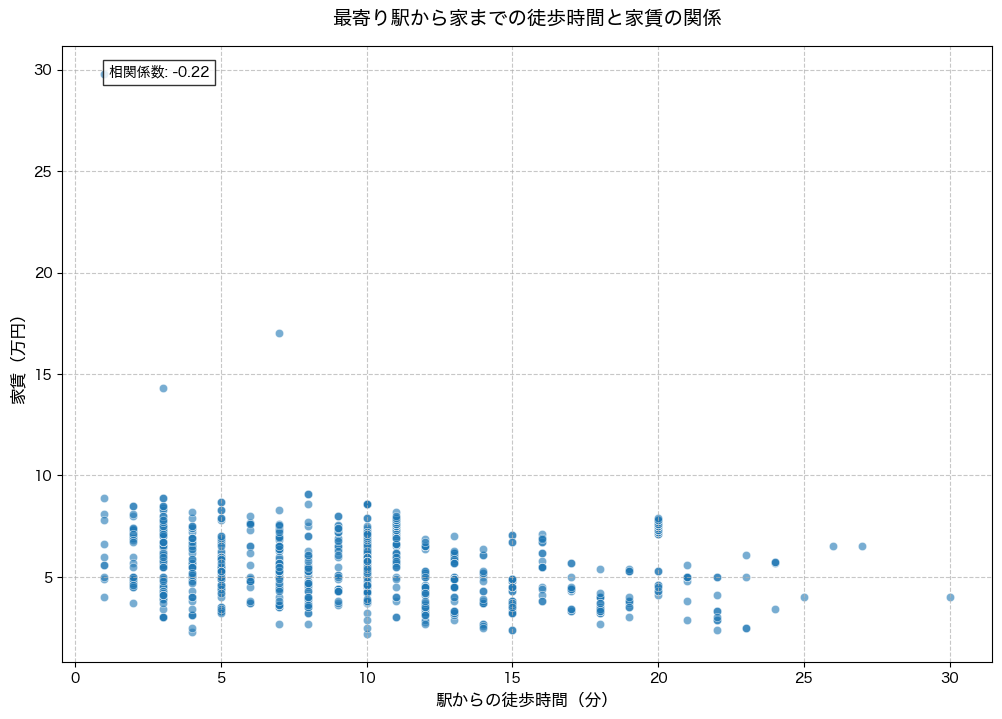


基本統計量:
           家賃（万円）     徒歩時間（分）
count  923.000000  923.000000
mean     5.589415    9.586132
std      1.748903    5.461351
min      2.200000    1.000000
25%      4.400000    5.000000
50%      5.500000   10.000000
75%      6.700000   13.000000
max     29.800000   30.000000

総物件数: 927
徒歩圏内の物件数: 923
徒歩圏内物件の割合: 99.6%


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import sqlite3
import logging

# ロギング設定
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='property_analysis.log'
)

def connect_to_db():
    """データベースに接続する関数"""
    try:
        conn = sqlite3.connect('suumo_properties.db')
        return conn
    except Exception as e:
        logging.error(f"データベース接続エラー: {e}")
        raise

def extract_walking_time(station_info):
    """
    駅情報から徒歩時間（分）を抽出する関数
    例: 'JR高崎線/本庄駅 歩24分' → 24
    """
    if pd.isna(station_info):
        return np.nan
    
    pattern = r'歩(\d+)分'
    match = re.search(pattern, station_info)
    
    if match and 'バス' not in station_info:
        return int(match.group(1))
    return np.nan

def clean_rent(value):
    """
    家賃データをクリーニングする関数
    例: '5.2万円' → 5.2
    """
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if '万円' in value:
            return float(value.replace('万円', ''))
    return value

def create_station_rent_scatter():
    """
    駅からの徒歩時間と家賃の散布図を作成する関数
    """
    try:
        # データベースに接続
        conn = connect_to_db()
        
        # SQLクエリでデータを取得
        query = """
        SELECT rent, nearest_station1
        FROM properties 
        WHERE rent != '不明' AND nearest_station1 != '不明'
        """
        df = pd.read_sql_query(query, conn)
        
        # データのクリーニング
        df['rent_cleaned'] = df['rent'].apply(clean_rent)
        df['walking_time'] = df['nearest_station1'].apply(extract_walking_time)
        
        # 欠損値を除外
        df_clean = df.dropna(subset=['rent_cleaned', 'walking_time'])
        
        # プロットの設定
        plt.figure(figsize=(12, 8))
        
        # 散布図の作成
        sns.scatterplot(data=df_clean, 
                       x='walking_time', 
                       y='rent_cleaned',
                       alpha=0.6)
        
        # グラフの設定
        plt.title('最寄り駅から家までの徒歩時間と家賃の関係', fontsize=14, pad=15)
        plt.xlabel('駅からの徒歩時間（分）', fontsize=12)
        plt.ylabel('家賃（万円）', fontsize=12)
        
        # グリッド線の追加
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 相関係数の計算と表示
        correlation = df_clean['rent_cleaned'].corr(df_clean['walking_time'])
        plt.text(0.05, 0.95, f'相関係数: {correlation:.2f}', 
                 transform=plt.gca().transAxes, 
                 fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.8))
        
        # グラフの表示
        plt.show()
        
        # 基本統計量の表示
        print("\n基本統計量:")
        stats = pd.DataFrame({
            '家賃（万円）': df_clean['rent_cleaned'].describe(),
            '徒歩時間（分）': df_clean['walking_time'].describe()
        })
        print(stats)
        
        # データ数の表示
        total_properties = len(df)
        walking_properties = len(df_clean)
        print(f"\n総物件数: {total_properties}")
        print(f"徒歩圏内の物件数: {walking_properties}")
        print(f"徒歩圏内物件の割合: {(walking_properties/total_properties*100):.1f}%")
        
    except Exception as e:
        logging.error(f"分析中にエラー発生: {e}")
        print(f"エラー: {e}")
        
    finally:
        # データベース接続のクローズ
        if 'conn' in locals():
            conn.close()
            logging.info('データベース接続を終了しました')

if __name__ == "__main__":
    create_station_rent_scatter()

### 埼玉県本庄市の物件情報をスクレイピング

In [20]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib.parse
import time
import numpy as np
import pandas as pd
import logging
import sqlite3
from datetime import datetime

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='honjo_scraping.log'
)

# ヘッダー設定
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# SUUMOを本庄市に絞る
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=11&sc=11211&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&srch_navi=1'

def get_total_pages(soup):
    """
    検索結果の総ページ数を取得する関数
    
    Args:
        soup (BeautifulSoup): BeautifulSoupオブジェクト
    
    Returns:
        int: 総ページ数。取得できない場合は1を返す
    """
    try:
        pagination = soup.find(class_='pagination pagination_set-nav')
        if pagination:
            pages = pagination.find_all('a')
            if pages:
                return int(pages[-2].text)
        return 1
    except Exception as e:
        logging.error(f"総ページ数の取得に失敗: {e}")
        return 1

class RateLimiter:
    def __init__(self, requests_per_second=1):
        self.requests_per_second = requests_per_second
        self.last_request_time = 0

    def wait(self):
        current_time = time.time()
        elapsed_time = current_time - self.last_request_time
        if elapsed_time < (1 / self.requests_per_second):
            time.sleep((1 / self.requests_per_second) - elapsed_time)
        self.last_request_time = time.time()

class ScrapingCounter:
    def __init__(self):
        self.total_properties = 0
        self.total_buildings = 0
        self.properties_per_page = []
    
    def add_page_stats(self, buildings, properties):
        self.total_buildings += buildings
        self.total_properties += properties
        self.properties_per_page.append(properties)
    
    def get_stats(self):
        return {
            'total_properties': self.total_properties,
            'total_buildings': self.total_buildings,
            'avg_properties_per_page': np.mean(self.properties_per_page) if self.properties_per_page else 0
        }

def init_database():
    conn = sqlite3.connect('honjo_properties.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        category TEXT,
        building_name TEXT,
        address TEXT,
        nearest_station1 TEXT,
        nearest_station2 TEXT,
        nearest_station3 TEXT,
        building_age TEXT,
        total_floors TEXT,
        room_floor TEXT,
        rent TEXT,
        management_fee TEXT,
        deposit TEXT,
        gratuity TEXT,
        layout TEXT,
        area TEXT,
        url TEXT,
        page_number INTEGER
    )
    ''')
    
    conn.commit()
    return conn, cursor

def insert_to_database(conn, cursor, data_samples, current_page, rate_limiter, counter):
    scrape_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    insert_query = '''
    INSERT INTO properties (
        scrape_date, category, building_name, address, 
        nearest_station1, nearest_station2, nearest_station3, building_age, 
        total_floors, room_floor, rent, management_fee, 
        deposit, gratuity, layout, area, url, page_number
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    '''
    
    insert_data = []
    for sample in data_samples:
        insert_data.append((
            scrape_date, 
            sample[0], sample[1], sample[2], 
            sample[3], sample[4], sample[5], sample[6], 
            sample[7], sample[8], sample[9], sample[10], 
            sample[11], sample[12], sample[13], sample[14],
            sample[15], current_page
        ))
        
        rate_limiter.wait()
        print("---物件情報---")
        print(f"データ件数：{counter.total_properties + 1}")
        print(f"カテゴリ: {sample[0]}")
        print(f"建物名: {sample[1]}")
        print(f"住所: {sample[2]}")
        print(f"最寄り駅1: {sample[3]}")
        print(f"最寄り駅2: {sample[4]}")
        print(f"最寄り駅3: {sample[5]}")
        print(f"築年数: {sample[6]}")
        print(f"総階数: {sample[7]}")
        print(f"部屋階: {sample[8]}")
        print(f"家賃: {sample[9]}")
        print(f"管理費: {sample[10]}")
        print(f"敷金: {sample[11]}")
        print(f"礼金: {sample[12]}")
        print(f"間取り: {sample[13]}")
        print(f"面積: {sample[14]}")
        print(f"URL: {sample[15]}")
        print("---------------\n")
        counter.total_properties += 1

    cursor.executemany(insert_query, insert_data)
    conn.commit()

@retry(tries=3, delay=10, backoff=2)
def load_page(url, rate_limiter):
    try:
        rate_limiter.wait()
        html = requests.get(url, headers=headers, timeout=10)
        html.raise_for_status()
        soup = BeautifulSoup(html.content, 'html.parser')
        return soup
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise
        
def export_to_csv(conn):
    try:
        # SQLクエリを実行してデータフレームを作成
        df = pd.read_sql_query("SELECT * FROM properties", conn)
        
        # ファイル名を生成
        filename = f'honjo_properties_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
        
        # CSVファイルに出力（エンコーディングを指定）
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        logging.info(f'CSVファイル {filename} を出力しました')
        print(f"\nCSVファイル {filename} に出力しました。")
        
        # データ概要の出力
        print("\n--- データ概要 ---")
        print(f"総物件数: {len(df)}")
        
        # 家賃の平均を計算
        try:
            # 万円を除去して数値に変換
            df['rent_numeric'] = df['rent'].str.extract(r'(\d+\.?\d*)').astype(float)
            mean_rent = df['rent_numeric'].mean()
            print(f"平均家賃: {mean_rent:.2f}万円")
        except Exception as e:
            logging.error(f"家賃の平均計算に失敗: {e}")
            print("家賃の平均計算に失敗しました。")
        
        # カテゴリ内訳を表示
        print(f"物件カテゴリ内訳:\n{df['category'].value_counts()}")
        
    except Exception as e:
        logging.error(f"CSVファイル出力中にエラー発生: {e}")
        print(f"CSVファイル出力中にエラーが発生しました: {e}")

def main():
    rate_limiter = RateLimiter(requests_per_second=1)
    counter = ScrapingCounter()
    
    conn, cursor = init_database()
    data_samples = []

    first_page_soup = load_page(url, rate_limiter)
    max_page = get_total_pages(first_page_soup)
    
    start = time.time()
    times = []

    try:
        for page in range(1, max_page+1):
            before = time.time()
            page_properties = 0
            
            page_url = f"{url}&page={page}" if page > 1 else url
            
            soup = load_page(page_url, rate_limiter)
            
            mother = soup.find_all(class_='cassetteitem')
            buildings_count = len(mother)
            
            for child in mother:
                data_home = []
                
                try:
                    data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_content-title').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_detail-col1').text)
                except:
                    data_home.append('不明')
                
                try:
                    children = child.find(class_='cassetteitem_detail-col2')
                    stations = children.find_all(class_='cassetteitem_detail-text')
                    for id, grandchild in enumerate(stations[:3]):
                        data_home.append(grandchild.text)
                    while len(data_home) < 6:
                        data_home.append('不明')
                except:
                    data_home.extend(['不明', '不明', '不明'])
                
                try:
                    children = child.find(class_='cassetteitem_detail-col3')
                    building_info = children.find_all('div')
                    data_home.extend([building_info[0].text, building_info[1].text])
                except:
                    data_home.extend(['不明', '不明'])

                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    
                    room_tds = room.find_all('td')
                    for id_, grandchild in enumerate(room_tds):
                        try:
                            if id_ == 2:
                                data_room.append(grandchild.text.strip())
                            
                            elif id_ == 3:
                                rent = grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text
                                management_fee = grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text
                                data_room.append(rent)
                                data_room.append(management_fee)
                            
                            elif id_ == 4:
                                deposit = grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text
                                gratuity = grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text
                                data_room.append(deposit)
                                data_room.append(gratuity)
                            
                            elif id_ == 5:
                                layout = grandchild.find(class_='cassetteitem_madori').text
                                area = grandchild.find(class_='cassetteitem_menseki').text
                                data_room.append(layout)
                                data_room.append(area)
                            
                            elif id_ == 8:
                                get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                                abs_url = urllib.parse.urljoin(url, get_url)
                                data_room.append(abs_url)
                        
                        except Exception as e:
                            data_room.append('不明')
                    
                    data_sample = data_home + data_room
                    data_samples.append(data_sample)
                    page_properties += 1
            
            counter.add_page_stats(buildings_count, page_properties)
            
            insert_to_database(conn, cursor, data_samples, page, rate_limiter, counter)
            data_samples = []
            
            after = time.time()
            running_time = after - before
            times.append(running_time)
            
            stats = counter.get_stats()
            print(f'\n{page}ページ目の統計:')
            print(f'このページの建物数: {buildings_count}')
            print(f'このページの物件数: {page_properties}')
            print(f'累計建物数: {stats["total_buildings"]}')
            print(f'累計物件数: {stats["total_properties"]}')
            print(f'ページあたり平均物件数: {stats["avg_properties_per_page"]:.1f}')
            print(f'処理時間: {running_time:.1f}秒')
            
            complete_ratio = round(page/max_page*100, 3)
            print(f'完了：{complete_ratio}%')
            
            running_mean = np.mean(times)
            running_required_time = running_mean * (max_page - page)
            hour = int(running_required_time/3600)
            minute = int((running_required_time%3600)/60)
            second = int(running_required_time%60)
            print(f'残り時間：{hour}時間{minute}分{second}秒\n')

            logging.info(f'ページ {page} スクレイピング完了 (建物数: {buildings_count}, 物件数: {page_properties})')

    except Exception as e:
        logging.error(f"スクレイピング中にエラー発生: {e}")
        print(f"エラー: {e}")
    
    finish = time.time()
    running_all = finish - start
    
    final_stats = counter.get_stats()
    print('\n=== 最終統計 ===')
    print(f'総建物数: {final_stats["total_buildings"]}')
    print(f'総物件数: {final_stats["total_properties"]}')
    print(f'ページあたり平均物件数: {final_stats["avg_properties_per_page"]:.1f}')
    print(f'総経過時間: {running_all:.1f}秒')

    export_to_csv(conn)
    conn.close()
    logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

---物件情報---
データ件数：45
カテゴリ: 賃貸アパート
建物名: コート・ノース本庄Ｂ
住所: 埼玉県本庄市寿３
最寄り駅1: ＪＲ高崎線/本庄駅 歩24分
最寄り駅2: 
最寄り駅3: 
築年数: 築11年
総階数: 3階建
部屋階: 2階
家賃: 4.85万円
管理費: 1700円
敷金: -
礼金: 4.85万円
間取り: 1LDK
面積: 41.3m2
URL: https://suumo.jp/chintai/jnc_000095747978/?bc=100417536669
---------------

---物件情報---
データ件数：46
カテゴリ: 賃貸アパート
建物名: ＪＲ高崎線 本庄駅 3階建 築11年
住所: 埼玉県本庄市寿３
最寄り駅1: ＪＲ高崎線/本庄駅 歩24分
最寄り駅2: 
最寄り駅3: 
築年数: 築11年
総階数: 3階建
部屋階: 2階
家賃: 4.85万円
管理費: 1700円
敷金: -
礼金: 4.85万円
間取り: 1LDK
面積: 41.3m2
URL: https://suumo.jp/chintai/jnc_000095756609/?bc=100417468564
---------------

---物件情報---
データ件数：47
カテゴリ: 賃貸アパート
建物名: パラッツィオ　ボスコ
住所: 埼玉県本庄市東富田
最寄り駅1: 上越新幹線/本庄早稲田駅 歩9分
最寄り駅2: 
最寄り駅3: 
築年数: 築19年
総階数: 2階建
部屋階: 1階
家賃: 5.8万円
管理費: 3000円
敷金: -
礼金: -
間取り: 2LDK
面積: 57.96m2
URL: https://suumo.jp/chintai/jnc_000065415677/?bc=100417743617
---------------

---物件情報---
データ件数：48
カテゴリ: 賃貸アパート
建物名: パラッツィオ　ボスコ
住所: 埼玉県本庄市東富田
最寄り駅1: 上越新幹線/本庄早稲田駅 歩9分
最寄り駅2: 
最寄り駅3: 
築年数: 築19年
総階数: 2階建
部屋階: 1階
家賃: 5.9万円
管理費: 3000円
敷金: -
礼金: -
間取り: 2LDK
面積: 57.96m2
URL: 

### 埼玉県本庄市の物件の最寄り駅から家までの時間と家賃の関係を散布図で表す

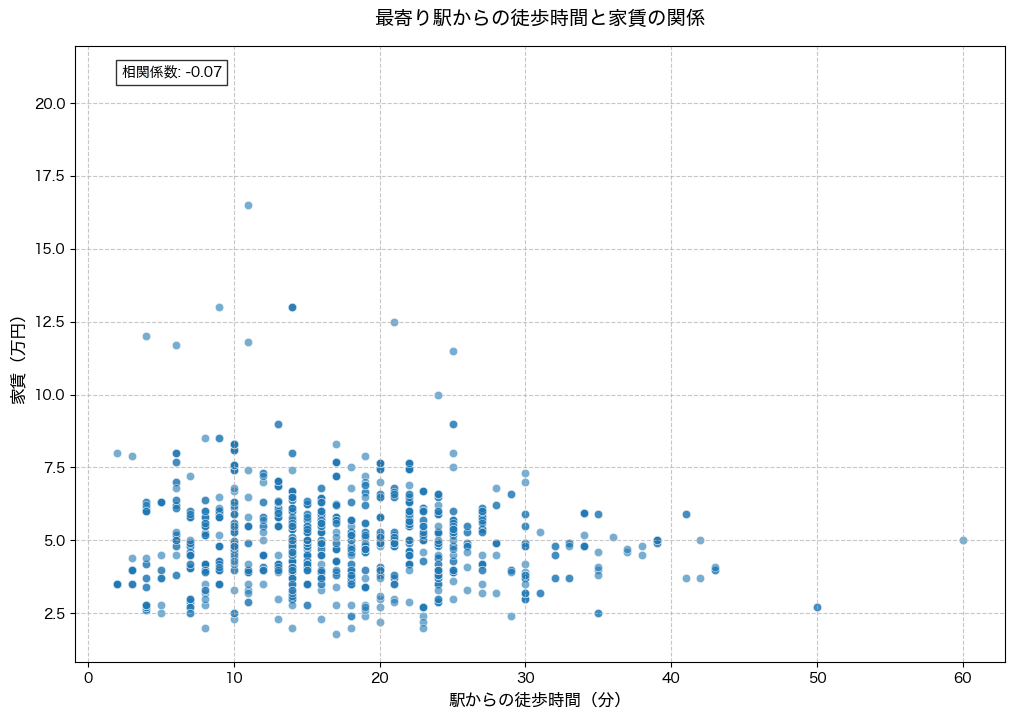


基本統計量:
            家賃（万円）      徒歩時間（分）
count  1364.000000  1364.000000
mean      5.172031    17.164223
std       1.493780     7.611881
min       1.800000     2.000000
25%       4.175000    13.000000
50%       5.100000    16.000000
75%       5.900000    22.000000
max      21.000000    60.000000

総物件数: 1489
徒歩圏内の物件数: 1364
徒歩圏内物件の割合: 91.6%


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import sqlite3
import logging

# ロギング設定
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='honjo_analysis.log'
)

def connect_to_db():
    """データベースに接続する関数"""
    try:
        conn = sqlite3.connect('honjo_properties.db')
        return conn
    except Exception as e:
        logging.error(f"データベース接続エラー: {e}")
        raise

def extract_walking_time(station_info):
    """
    駅情報から徒歩時間（分）を抽出する関数
    例: 'JR高崎線/本庄駅 歩24分' → 24
    """
    if pd.isna(station_info):
        return np.nan
    
    pattern = r'歩(\d+)分'
    match = re.search(pattern, station_info)
    
    if match and 'バス' not in station_info:
        return int(match.group(1))
    return np.nan

def clean_rent(value):
    """
    家賃データをクリーニングする関数
    例: '5.2万円' → 5.2
    """
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if '万円' in value:
            return float(value.replace('万円', ''))
    return value

def create_station_rent_scatter():
    """
    駅からの徒歩時間と家賃の散布図を作成する関数
    """
    try:
        # データベースに接続
        conn = connect_to_db()
        
        # SQLクエリでデータを取得
        query = """
        SELECT rent, nearest_station1
        FROM properties 
        WHERE rent != '不明' AND nearest_station1 != '不明'
        """
        df = pd.read_sql_query(query, conn)
        
        # データのクリーニング
        df['rent_cleaned'] = df['rent'].apply(clean_rent)
        df['walking_time'] = df['nearest_station1'].apply(extract_walking_time)
        
        # 欠損値を除外
        df_clean = df.dropna(subset=['rent_cleaned', 'walking_time'])
        
        # プロットの設定
        plt.figure(figsize=(12, 8))
        
        # 散布図の作成
        sns.scatterplot(data=df_clean, 
                       x='walking_time', 
                       y='rent_cleaned',
                       alpha=0.6)
        
        # グラフの設定
        plt.title('最寄り駅からの徒歩時間と家賃の関係', fontsize=14, pad=15)
        plt.xlabel('駅からの徒歩時間（分）', fontsize=12)
        plt.ylabel('家賃（万円）', fontsize=12)
        
        # グリッド線の追加
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 相関係数の計算と表示
        correlation = df_clean['rent_cleaned'].corr(df_clean['walking_time'])
        plt.text(0.05, 0.95, f'相関係数: {correlation:.2f}', 
                 transform=plt.gca().transAxes, 
                 fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.8))
        
        # グラフの表示
        plt.show()
        
        # 基本統計量の表示
        print("\n基本統計量:")
        stats = pd.DataFrame({
            '家賃（万円）': df_clean['rent_cleaned'].describe(),
            '徒歩時間（分）': df_clean['walking_time'].describe()
        })
        print(stats)
        
        # データ数の表示
        total_properties = len(df)
        walking_properties = len(df_clean)
        print(f"\n総物件数: {total_properties}")
        print(f"徒歩圏内の物件数: {walking_properties}")
        print(f"徒歩圏内物件の割合: {(walking_properties/total_properties*100):.1f}%")
        
    except Exception as e:
        logging.error(f"分析中にエラー発生: {e}")
        print(f"エラー: {e}")
        
    finally:
        # データベース接続のクローズ
        if 'conn' in locals():
            conn.close()
            logging.info('データベース接続を終了しました')

if __name__ == "__main__":
    create_station_rent_scatter()

### 埼玉県本庄市の物件の面積と家賃の関係を散布図で表す

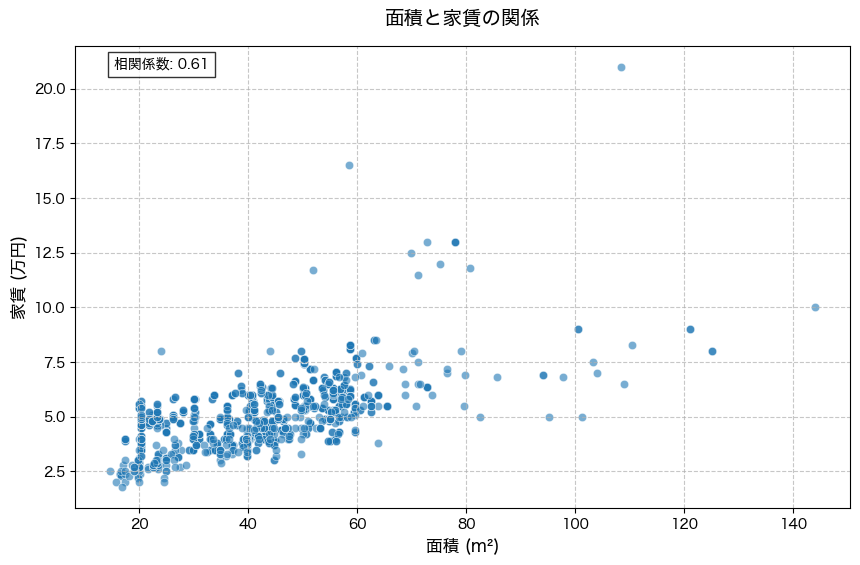


基本統計量:
           家賃 (万円)      面積 (m²)
count  1489.000000  1489.000000
mean      5.155473    41.455957
std       1.444785    15.730483
min       1.800000    14.650000
25%       4.200000    27.400000
50%       5.000000    41.810000
75%       5.900000    51.360000
max      21.000000   143.930000


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import logging

# ロギング設定
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='honjo_analysis.log'
)

def connect_to_db():
    """データベースに接続する関数"""
    try:
        conn = sqlite3.connect('honjo_properties.db')
        return conn
    except Exception as e:
        logging.error(f"データベース接続エラー: {e}")
        raise

def clean_numeric_data(value):
    """数値データをクリーニングする関数"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        # 家賃データのクリーニング（例：'5.2万円' → 5.2）
        if '万円' in value:
            return float(value.replace('万円', ''))
        # 面積データのクリーニング（例：'45m2' → 45.0）
        if 'm2' in value:
            return float(value.replace('m2', ''))
    return value

def create_rent_area_scatter():
    """家賃と面積の散布図を作成する関数"""
    try:
        # データベースに接続
        conn = connect_to_db()
        
        # SQLクエリでデータを取得
        query = """
        SELECT rent, area 
        FROM properties 
        WHERE rent != '不明' AND area != '不明'
        """
        df = pd.read_sql_query(query, conn)
        
        # データのクリーニング
        df['rent_cleaned'] = df['rent'].apply(clean_numeric_data)
        df['area_cleaned'] = df['area'].apply(clean_numeric_data)
        
        # 欠損値を除外
        df_clean = df.dropna(subset=['rent_cleaned', 'area_cleaned'])
        
        # プロットの設定
        plt.figure(figsize=(10, 6))
        
        # 散布図の作成
        sns.scatterplot(data=df_clean, 
                       x='area_cleaned', 
                       y='rent_cleaned',
                       alpha=0.6)
        
        # グラフの設定
        plt.title('面積と家賃の関係', fontsize=14, pad=15)
        plt.xlabel('面積 (m²)', fontsize=12)
        plt.ylabel('家賃 (万円)', fontsize=12)
        
        # グリッド線の追加
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 相関係数の計算と表示
        correlation = df_clean['rent_cleaned'].corr(df_clean['area_cleaned'])
        plt.text(0.05, 0.95, f'相関係数: {correlation:.2f}', 
                 transform=plt.gca().transAxes, 
                 fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.8))
        
        # グラフの表示
        plt.show()
        
        # 基本統計量の表示
        print("\n基本統計量:")
        stats = pd.DataFrame({
            '家賃 (万円)': df_clean['rent_cleaned'].describe(),
            '面積 (m²)': df_clean['area_cleaned'].describe()
        })
        print(stats)
        
    except Exception as e:
        logging.error(f"分析中にエラー発生: {e}")
        print(f"エラー: {e}")
        
    finally:
        # データベース接続のクローズ
        if 'conn' in locals():
            conn.close()
            logging.info('データベース接続を終了しました')

if __name__ == "__main__":
    create_rent_area_scatter()